In [1]:
from pypde import *
import matplotlib.pyplot as plt
initplot()

class Temperature(Integrator):
    CONFIG={
        "shape": (50,50),
        "bases": ("CN","CD"),
        "kappa": 1.0,
        "dt": 0.2,
        "ndim": 2,
        "tsave": 0.1,
    }
    def __init__(self,**kwargs):
        Integrator.__init__(self)
        self.__dict__.update(**self.CONFIG)
        self.__dict__.update(**kwargs)
        xbase = Base(self.shape[0],self.bases[0])
        ybase = Base(self.shape[1],self.bases[1])
        # Field
        self.field = Field( [xbase,ybase])
        # Boundary Conditions
        self.setup_fieldbc()
        # Solver
        self.setup_solver()
        # Initialize field
        self.init_field()
        self.field.save()
        
        # Space for derivatives
        xbase = Base(self.shape[0],"CH")
        ybase = Base(self.shape[1],"CH")
        self.deriv_field = Field( [xbase,ybase] )
        
    def setup_fieldbc(self):
        ''' Setup Inhomogeneous field'''
        # Boundary Conditions T 1, 0
        bc = np.zeros((self.shape[0],2))
        bc[:,0] = 1.0
        
        xbase = Base(self.shape[0],self.bases[0])
        ybase = Base(self.shape[1],self.bases[1])
        self.fieldbc = FieldBC([xbase,ybase],axis=1)
        self.fieldbc.add_bc(bc)
        
    def setup_solver(self):
        from pypde.templates.hholtz import solverplan_hholtz2d_adi
        self.solver = solverplan_hholtz2d_adi(
            bases=self.field.xs,lam=self.dt*self.kappa)
    
    def init_field(self):
        #self.field.v = -self.fieldbc.v
        self.field.v[:] = 0
        self.field.forward()
        self.field.backward()
    
    @property
    @memoized
    def bc_d2Tdz2(self):
        return grad(self.fieldbc,deriv=(0,2),return_field=True)
    
    @property
    @memoized
    def bc_dTdz(self):
        return grad(self.fieldbc,deriv=(0,1),return_field=True)
        #return -0.5
    
    #def nonlin(self,ux,uz):
    #    '''
    #    Returns field of nonlinear advection.
    #    Already transform into spectral space.
    #    
    #    ux,uz must contain fields in physical
    #    space (already back transformed)
    #    '''
    #    assert np.all([isinstance(i,Field)for i in [ux,uz]])
    #    
    #    dfield = Field( self.shape, ("CH","CH") )
    #    self.field.backward()
    #    
    #    # ux dTdx
    #    dfield.v = ux.v*self.field.v
    #    dfield.forward()
    #    nonlin = grad( dfield, (1,0) )
    #    
    #    # uz dTdz
    #    dfield.v = uz.v*self.field.v
    #    dfield.forward()
    #    nonlin += grad( dfield, (0,1) )
    #    
    #    # uz dTdz (from bc)
    #    dfield.v = uz.v*self.bc_dTdz.v
    #    dfield.forward() 
    #    dfield.vhat += nonlin

    #    return dfield
    

    
    def nonlin(self,ux,uz):
        '''
        Returns field of nonlinear advection.
        Already transform into spectral space.
        
        ux,uz must contain fields in physical
        space (already back transformed)
        '''
        assert np.all([isinstance(i,Field)for i in [ux,uz]])
        
        # ux dTdx
        dTdx = grad( self.field, (1,0), True )
        nonlin = ux.v*dTdx.v
        
        # uz dTdz
        dTdz = grad( self.field, (0,1), True )
        nonlin += uz.v*dTdz.v
        
        # uz dTdz (from bc)
        nonlin += uz.v*self.bc_dTdz.v
        
        # Transform back
        self.deriv_field.v = nonlin
        self.deriv_field.forward()

        return self.deriv_field
                                 
    
    def update(self,ux_field=None,uz_field=None):
        ''' (1-D2)v = D2 v_bc + vold'''
            
            
        rhs = self.dt*self.kappa*self.bc_d2Tdz2.vhat
        if ux_field is not None and uz_field is not None:
            rhs -= self.dt*self.nonlin(ux_field,uz_field).vhat
        
        
        rhs  = self.solver.solve_rhs(  rhs )
        rhs += self.solver.solve_old(self.field.vhat)
        
        self.field.vhat[:] = self.solver.solve_lhs(rhs)

set color cycle ...
register goldfish colorbar as 'gfcmap' ...
update rc params to default ...


In [2]:
shape = (60,60)

xbase = Base(shape[0],"CN")
ybase = Base(shape[1],"CD")
    
T  = Temperature(shape=shape)
ux = Field([xbase,ybase])
uz = Field([xbase,ybase])

x,y = T.field.x, T.field.y
xx,yy = np.meshgrid(x,y,indexing="ij")

## Set velocity fields

In [3]:
m,n = 1,1
ux.v =  2*np.cos(0.5*m*np.pi*xx)*np.sin(1.0*n*np.pi*yy)
uz.v = -2*np.sin(1.0*m*np.pi*xx)*np.cos(0.5*n*np.pi*yy)



## Solve

In [4]:
#%%time

D = Temperature(shape=shape,dt=0.002,tsave=0.5,kappa=0.01)
D.iterate(5.0,ux_field = ux, uz_field=uz)

Time: 0.500
Time: 1.000
Time: 1.500
Time: 2.000
Time: 2.500
Time: 3.000
Time: 3.500
Time: 4.000
Time: 4.500
Time: 5.000


Save animation to out/anim.mp4


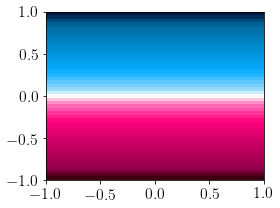

In [10]:
from IPython.display import HTML

#  Add inhomogeneous part
if D.field.V[0][0,0] < 0.1:
    for i,v in enumerate(D.field.V):
        D.field.V[i] += D.fieldbc.v

anim = D.field.animate(duration=4)
#plt.close("all")
HTML(anim.to_jshtml())
#plt.close("all")

In [13]:
a = np.arange(10)
N = a.size
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
def pad(array, reference_shape):
    """
    array: Array to be padded
    reference_shape: tuple of size of ndarray to create
    offsets: list of offsets (number of elements must be equal to the dimension of the array)
    will throw a ValueError if offsets is too big and the reference_shape cannot handle the offsets
    """
    # Create an array of zeros with the reference shape
    result = np.zeros(reference_shape)
    slices = [slice(0, array.shape[dim]) for dim in range(array.ndim)]
    result[slices] = array
    return result

In [23]:
a = np.array([ [ 1.,  1.],
               [ 1.,  1.] ])

In [26]:
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):

    pad_size = target_length - array.shape[axis]

    if pad_size <= 0:
        return array

    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)

    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

pad_along_axis(a,3,1)

array([[1., 1., 0.],
       [1., 1., 0.]])